## Model Training

### Data Reading

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("df_final.csv")

In [3]:
df.head()

,DATE,p_saving_rate,target,mortgage_rate,IPI_Cement,PPI_Cement,permit,PPI_Concrete,population,new_private_house,...,new_private_hw_under,GDP,home_ow_rate,house_st,total_emp_cons,labor_percent,all_Const_Emp,monthly_supply,unemployed_rate,MSPUS
0,1987-01-01,9.4,63.735,9.2040,123.7373,100.1,1690.0,4.703204,241857.0,7974.739004,...,1090.0,4722.156,63.9,1774.0,5007.0,65.4,722.3,6.0,6.6,97900.0
1,1987-02-01,8.2,64.135,9.0825,123.1670,100.8,1689.0,4.703204,242005.0,7502.244305,...,1096.0,4722.156,63.9,1784.0,5038.0,65.5,724.2,6.2,6.6,97900.0
2,1987-03-01,8.1,64.470,9.0350,122.5706,101.2,1704.0,4.703204,242166.0,7106.570176,...,1084.0,4722.156,63.9,1726.0,5039.0,65.5,727.9,6.0,6.6,97900.0
3,1987-04-01,4.1,64.973,9.8325,123.5345,100.8,1601.0,4.703204,242338.0,7316.773819,...,1079.0,4806.160,63.9,1614.0,5053.0,65.4,728.1,6.0,6.3,103400.0
4,1987-05-01,7.8,65.547,10.5960,123.8454,101.2,1500.0,4.697749,242516.0,7203.844501,...,1070.0,4806.160,63.9,1628.0,5080.0,65.7,727.6,6.7,6.3,103400.0


### Data splitting and Scaling

In [4]:
X = df.drop(columns=['DATE', 'target'], axis=1)
y = df.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training

In [8]:
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 4, 100),cv=5)

lasso_cv_model.fit(X_train, y_train)

lasso_cv_predictions = lasso_cv_model.predict(X_test)

In [9]:
optimal_alpha = lasso_cv_model.alpha_

mse = mean_squared_error(y_test, lasso_cv_predictions)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, lasso_cv_predictions)

print(f"Optimal Alpha: {optimal_alpha:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"RMSE: {rmse:2f}")
print(f"R-squared (R2): {r2:.2f}")

Optimal Alpha: 0.0576
Mean Squared Error (MSE): 17.81
RMSE: 4.219696
R-squared (R2): 1.00


### Cross validation

In [17]:
cross_val_scores = cross_val_score(lasso_cv_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R-squared Scores:")
print(cross_val_scores)

Cross-Validation R-squared Scores:
[0.99521523 0.99394968 0.99332468 0.99258188 0.99323732]


In [18]:
mean_r2 = cross_val_scores.mean()
std_r2 = cross_val_scores.std()

print(f"Mean R-squared: {mean_r2:.4f}")
print(f"Standard Deviation of R-squared: {std_r2:.4f}")

Mean R-squared: 0.9937
Standard Deviation of R-squared: 0.0009


In [10]:
print(0.1 * rmse)
print(0.1 * df['target'].mean()) # rmse should be less than the 10% of mean of target variable

0.4219696130817074
14.11514874715262


### Most Prominent features and least prominent features

In [11]:
# coefficients and corresponding feature names
lasso_coefficients = lasso_cv_model.coef_
feature_names = X.columns

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})

non_zero_coefficients_df = coefficients_df[coefficients_df['Coefficient'] != 0]
zero_coefficients_df = coefficients_df[coefficients_df['Coefficient'] == 0]

In [12]:
non_zero_coefficients_df

,Feature,Coefficient
0,p_saving_rate,-0.923351
2,IPI_Cement,0.196152
5,PPI_Concrete,16.893031
6,population,-8.945503
10,new_private_hw_under,4.770749
11,GDP,18.499826
13,house_st,2.103615
15,labor_percent,1.501053
16,all_Const_Emp,10.887265
17,monthly_supply,3.212566


In [13]:
zero_coefficients_df

,Feature,Coefficient
1,mortgage_rate,-0.0
3,PPI_Cement,-0.0
4,permit,0.0
7,new_private_house,0.0
8,emratio,0.0
9,income,0.0
12,home_ow_rate,0.0
14,total_emp_cons,-0.0


### Predicted vs Observed

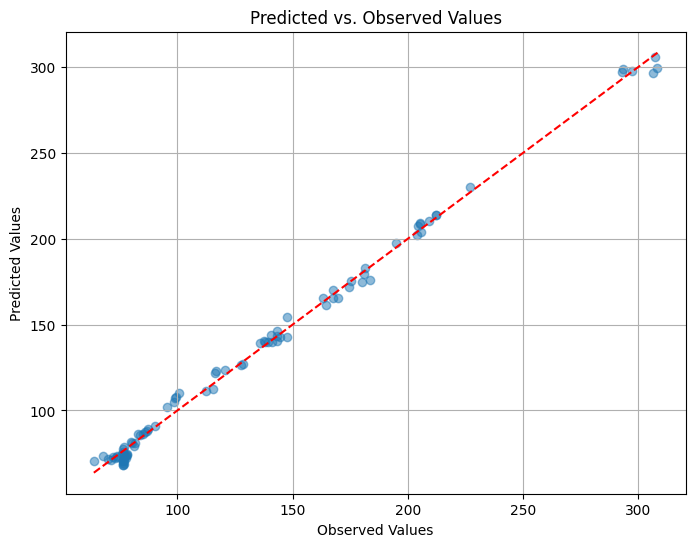

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, lasso_cv_predictions, alpha=0.5)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Observed Values")
plt.grid(True)

# Add a diagonal line for reference (perfect predictions)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--')

plt.show()